<a href="https://colab.research.google.com/github/sotetsuk/LectureColab/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
class VAE(nn.Module):
    def __init__(self, remove_var=False):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 500), nn.Tanh()
        )
        self.mu = nn.Linear(500, 2)
        self.log_var = nn.Linear(500, 2)
        self.noise = torch.distributions.Normal(0, 1)
        self.decoder = nn.Sequential(
            nn.Linear(2, 500), nn.Tanh(), nn.Linear(500, 784), nn.Sigmoid(),
        )
        self.remove_var = remove_var

    def encode(self, x):
        x = self.encoder(x)
        mu =  self.mu(x)
        log_var = self.log_var(x)
        var = log_var.exp()
        sigma = torch.sqrt(var)
        z = mu + sigma * self.noise.sample(mu.size())
        kl = - (1 + log_var - mu ** 2 - var).sum() / 2.
        return (z, kl) if not self.remove_var else (mu, 0)

    def forward(self, x):
        z, kl = self.encode(x)
        return self.decoder(z), kl

In [3]:
train_data = torch.utils.data.DataLoader(
              torchvision.datasets.MNIST(
                     '/tmp/mnist',
                     train=True,
                     transform=T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))]),
                     download=True),
              batch_size=256,
              shuffle=True)

test_data = torch.utils.data.DataLoader(
              torchvision.datasets.MNIST(
                     '/tmp/mnist',
                     train=False,
                     transform=T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))]),
                     download=True),
              batch_size=256,
              shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.42MB/s]


In [6]:
vae = VAE(remove_var=False)
vae.train()
optim = torch.optim.Adagrad(vae.parameters())
losses = []
for _ in tqdm(range(15)):
    avg_loss = None
    for x, y in train_data:
        x_hat, kl = vae(x)
        loss = ((x - x_hat) ** 2).sum() + kl
        loss.backward()
        optim.step()
        optim.zero_grad()
        avg_loss = loss.item() if avg_loss is None else avg_loss * 0.99 + loss.item() * 0.01
    losses.append(avg_loss)

100%|██████████| 15/15 [03:54<00:00, 15.62s/it]


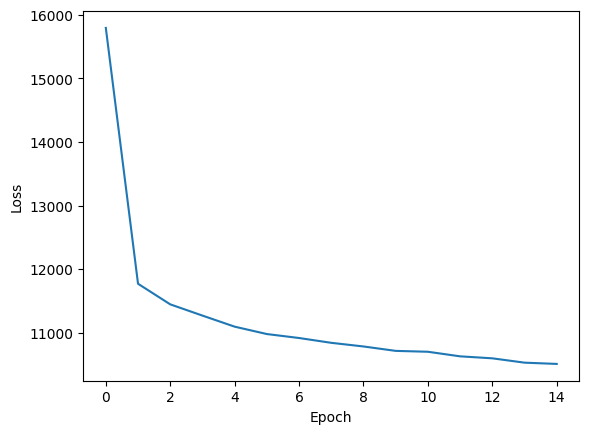

In [7]:
# Check loss
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

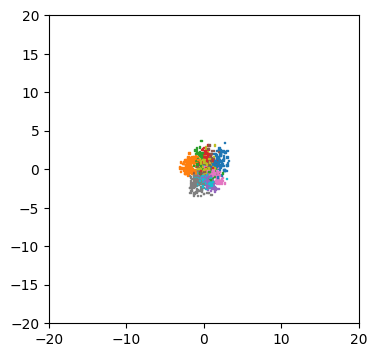

In [26]:
# Plot latent space
vae.eval()
plt.figure(figsize=(4, 4))
plt.xlim(-20, 20)
plt.ylim(-20, 20)
n = 0
for x, y in test_data:
    z, _ = vae.encode(x)
    z = z.detach()
    plt.scatter(z[:, 0], z[:, 1], marker=",", s=1, c=y, cmap='tab10')
    n += z.size(0)
    if n > 1000:
        break
plt.show()

In [23]:
ae = VAE(remove_var=True)
ae.train()
optim = torch.optim.Adagrad(ae.parameters())
losses = []
for _ in tqdm(range(15)):
    avg_loss = None
    for x, y in train_data:
        x_hat, _ = ae(x)
        loss = ((x - x_hat) ** 2).sum()
        loss.backward()
        optim.step()
        optim.zero_grad()
        avg_loss = loss.item() if avg_loss is None else avg_loss * 0.99 + loss.item() * 0.01
    losses.append(avg_loss)

100%|██████████| 15/15 [04:01<00:00, 16.09s/it]


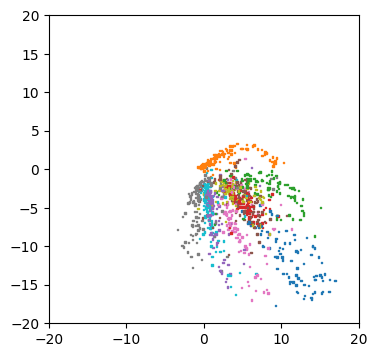

In [25]:
# Plot latent space
ae.eval()
plt.figure(figsize=(4, 4))
plt.xlim(-20, 20)
plt.ylim(-20, 20)
n = 0
for x, y in test_data:
    z, _ = ae.encode(x)
    z = z.detach()
    plt.scatter(z[:, 0], z[:, 1], marker=",", s=1, c=y, cmap='tab10')
    n += z.size(0)
    if n > 1000:
        break
plt.show()

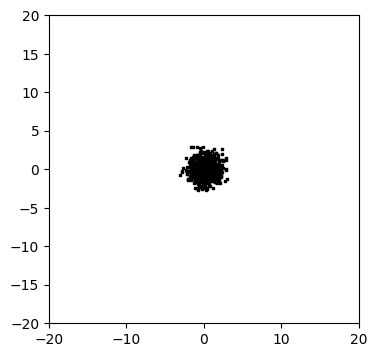

In [27]:
# Compare w/ prior
plt.figure(figsize=(4, 4))
plt.xlim(-20, 20)
plt.ylim(-20, 20)
z = torch.distributions.Normal(0, 1).sample((1000, 2))
plt.scatter(z[:, 0], z[:, 1], marker=",", s=1, c='k')
plt.show()